## Spark Pipelines and Evaluation of Scaling of Algorithms

### by Shakeel Raja, thanks to my buddy Nalan


## Task A - DATASET (20 NEWSGROUP)

The dataset selected for this experiment is “20 Newsgroup Dataset” [1], which was originally created by Ken Lang for development of “NewsWeeder”, a system for learning user profiles based on their news article ratings [2]. The dataset is compiled from 20 different newsgroups, containing approximately one thousand documents for each newsgroup. This results as an offering of a total of  roughly 20,000 text documents from a variety of domains. The dataset is balanced having similar number of document offerings for each domain (i.e. approx. 1000). Some of these domains are very similar to each other i.e. “comp.sys.ibm.pc.hardware” and “comp.sys.mac.hardware’, while some domains are highly unrelated e.g. “sci.electronics” and “talk.religion.misc”. The variety, size, shape and presence of a ground truth makes  “20 Newsgroup Dataset”  an ideal candidate for practicing supervised multiclass text classification and other similar tasks within the big data domain.  Following table shows including newsgroups domains, grouped according to topic similarity  
![Dataset Description](https://iscientiaqueueqa.blob.core.windows.net/samplecontainer/Capture.PNG)

### DATA CLEANING

Documents available in the newsgroup dataset carry headers with text information that may not be suitable or useful for analytical experimentation. Part of headers contained information generated as a part of communication protocols (i.e. IP addresses, email addresses, document locations etc. ) which would not have provided any insight into the real content of the document. The topic of document was also present within the header as text information in most cases, as shown the example below. This would have led to an artificially high accuracy rate. 
It was hence decided to remove this information from the documents prior to carrying out any further pre-processing and analysis tasks. This was achieved by iterating through all the documents in the corpus, identifying the location where the header terminates and removing the part of document upto that point. The resulting data frames were then subjected to further experiment. 

#### An example Header 

>Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49960 alt.atheism.moderated:713 news.answers:7054 alt.answers:126
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!magnus.acs.ohio-state.edu!usenet.ins.cwru.edu!agate!spool.mu.edu!uunet!pipex!ibmpcug!mantis!mathew
From: mathew <mathew@mantis.co.uk>
Newsgroups: alt.atheism,alt.atheism.moderated,news.answers,alt.answers
Subject: Alt.Atheism FAQ: Atheist Resources
Summary: Books, addresses, music -- anything related to atheism
Keywords: FAQ, atheism, books, music, fiction, addresses, contacts
Message-ID: <19930329115719@mantis.co.uk>
Date: Mon, 29 Mar 1993 11:57:19 GMT
Expires: Thu, 29 Apr 1993 11:57:19 GMT
Followup-To: alt.atheism
Distribution: world
Organization: Mantis Consultants, Cambridge. UK.
Approved: news-answers-request@mit.edu
Supersedes: <19930301143317@mantis.co.uk>
Lines: 290

### TEXT CLASSIFICATION
For this experiment, the selected dataset was subjected to text classification task. Text classification can be described predicting a topic for given text document as below:


### INPUT : 
#### A document ‘d’
#### A  predefined set of ‘j’ classes  C = {c1,c2,…,cj}

### OUTPUT: 
####  A predicted class c ∈ C

Text classification was chosen as an experiment of choice because it provides conceptual views of text corpuses and has various applications in the real world. E.g. organizing news stories by topic or location, research publications are classified by domains and subdomains, health-care systems often index patient reports from multiple views, taxonomies of disease classification and medical procedures, client document management for businesses and spam filtering etc. 

### BACKGROUND
Traditional AI based computing approach to automatic text classification involved manually defining a set of orthography rules [3] for entity recognition from given text but this proved to be time-consuming and expensive. For example, To label a sequence of tokens in the format 
“Mr. X”, where ‘X’ is a capitalized word representing the ‘Person’ entity, an expert may define following rule for identify the person: 

#### (token = “Mr.” orthography type = FirstCap) -> Person’s Name 


Here, the regular expression on the left side of rule identifies a given sequence of two tokens, where the first token “Mr.” is followed by orthography type “FirstCap” and the decision on right identifies the token as a person’s name.  Manually creating such rules for classification oriented entity recognition may achieve high accuracy with carefully refined rules but requires human expertise and is highly labour intensive [4].

### STATISTICAL MACHINE LEARNING: 

Statistical tasks treat categorization problems as “ Sequence Labelling Problems”. For a given sequence of observations in the text document, expressed as x = (x1,x2, … , xn), each observation is represented using a feature vector. The task requires assignment of a class label ci to each observation xi, considering that ci depends not only on xi but also on other observations and other labels within that sequence. To achieve this goal, each word in a sentence is treated as an observation. 
A text classification problem requires the presence of a corpus with annotated document-label relations as positive training examples. Statistical machine learning algorithms are then used for training classifiers i.e. logistic regression, Naive Bayes etc. [4].

## Task B - Machine Learning with Pipelines in Spark 

Apache Spark offers Pipelines to facilitate the creation, tuning, and testing of practical machine learning algorithm along with deployment. Pipelines offer functionality to define and monitor the entire data extraction, transformation, and algorithm training workflow. The data cleaning step (header removal) was performed at the dataset and resulting documents were labelled according to the topic name. Finally, a single dataframe with document text as rows and topic labels was generated for further experimentation. These steps and the resulting output has been shown in the code below:

In [2]:
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
import os
import re
from operator import add

#get the list of folders in the main directory
topicList = os.listdir("/data/tempstore/newsgroups/")
#remove the non folder in the list
topicList.remove('.DS_Store');

#create a small tempory list for speedup the experiments
#topicList = ['soc.religion.christian', 'rec.sport.baseball','comp.graphics'];

#define the prefix to load the data folders
prefix = '/data/tempstore/newsgroups/'

# remove the headers, get the sender and the main text
def parseMessage(ft): 
    
    fn,text = ft # unpack the filename and text content   
    #As we understand two newlines together is the most common pattern to remove the headers.
    #almost every file header ends with two new lines. regex expressions for python gave errors and we have used normal string 
    #calculations here
    #fist split the text by newline.
    lines = text.split("\n"); 
    
    #then look for the first empty item. because when 2 newlines together 2nd line dosen't contain anything 
    index = lines.index("")
    #safe check. if there are no 2 newlines 
    if(index < len(lines)):
        #if there are then get the sub list of strings from that index
        cleanLines = lines[index:len(lines)];
        #joins the strings list together to make a one string 
        newText = " ".join(cleanLines);
        #returns file name and string
        return (fn,newText)
    else:
        #if there are no new lines returns complete text
        return (fn,text)
    

# we need a SparkSession to create DataFrames
spark = SparkSession.builder.getOrCreate()

# Make a DataFrame with labels and n-Gram vectors 
def make_dataFrame(dirPath, argLabel): 
    #create rdd from the given file group (directory)
    ft_RDD = sc.wholeTextFiles(dirPath) 
    #parse through the remove header function. this returns a list of (fn,text)
    ft2_RDD = ft_RDD.map(parseMessage)  
    #rearrange the list to (text,label)
    fl_RDD = ft2_RDD.map(lambda ft: (ft[1], argLabel))
    
    #create a DataFrame with two coloumns.
    rows_DF = spark.createDataFrame(fl_RDD,schema=['text','label']) 
    
    return rows_DF

#create empty variable. we use this variable to hold the complete dataset as a dataframe. 
#we assign it to null initially
rows_DF = None;

#use the number to assign labels 0 - 19
number = 0;
#create a list to save the list of labels for generate charts
labelsAndCounts = [];

print("\tTopic Name \t\t  No of Items");

for topic in topicList:
    #make a dataframe for given topic and save it in a tempory variable
    rows_temp_DF = make_dataFrame(prefix+topic, number)
    
    #get the count of files in the news category
    count = rows_temp_DF.count()
 
    labelsAndCounts.append((topic,count));
    #just for printing purposes
    print("{0}\t\t\t\t{1}".format(topic,count))
        
    number = number + 1;
    #main dataframe is not null except in the first case. we merge the tempory df to main df
    if(rows_DF is not None):
        rows_DF = rows_DF.union(rows_temp_DF)
    else:
        #first case main dataframe is null and just assgin tempory df to main df
        rows_DF = rows_temp_DF;

#create a view called newsgroups in the dataframe
rows_DF.createOrReplaceTempView("newsgroups")


	Topic Name 		  No of Items
comp.sys.mac.hardware				1000
talk.politics.guns				998
rec.sport.hockey				1000
alt.atheism				1000
misc.forsale				1000
sci.space				1000
comp.sys.ibm.pc.hardware				1000
rec.autos				1000
sci.med				999
rec.sport.baseball				1000
soc.religion.christian				997
rec.motorcycles				1000
sci.crypt				1000
talk.politics.mideast				998
comp.windows.x				1000
talk.politics.misc				996
sci.electronics				1000
talk.religion.misc				998
comp.graphics				1000
comp.os.ms-windows.misc				1000


For text classification, The end to end document classification pipeline was implemented in spark with Apache’s machine learning library, Mllib.  Creating the pipeline involved declaration of all the required stages, configuring their parameters and chaining them in a pipeline object. After the removal of noisy data as described earlier, the documents were randomly split into testing and training sets and loaded into data-frames. This allowed us to define and create a Pipeline object for text classification with stages as defined below:

### Feature Transformers



#### Tokenizer
The ml tokenizer was used to convert text into words (terms) for creating vectors in later stages. 

#### Stop word removal
Stop word removal stage removes such words (terms) from the document that appear often with equal probability in each document and hence do not help with classification tasks. The “StopWordRemover” transformer from machine learning library was supplied with a list of commonly occurring stopwords as an extra parameter, taken from John Bresnik’s Github repository [6]. 

#### Hashing TF
Feature hashing, also known as the hashing trick, similar to the kernel trick, is a fast yet efficient way of vectorizing features. A raw feature is mapped into an index (term) by applying a hash function. Hashing  turns arbitrary features into indices in a vector or matrix by applying a hash function to the features and using their hash values as indices directly,instead of looking the indices up in an associative array.The hashingTF function in Spark Machine learning library was used for calculating hash vectors.  

Following code contains transformer definitions for Spark pipeline.

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import HashingTF, Tokenizer, IDF
from pyspark.ml.tuning import  ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rows_DF.persist()

#create small dataframe from getting subset from first two groups for testing purposes
test_small_DF = rows_DF.sampleBy( 'label', fractions={0:0.1,1:0.1}, seed=0 )

#format and count of the test dataset
#test_small_DF.groupBy('label').count().orderBy('label').show()

#define the list of stopwords
STOP_WORDS = [
    'a','cannot','into','our','thus','about','co','is','ours','to','above',
    'could','it','ourselves','together','across','down','its','out','too',
    'after','during','itself','over','toward','afterwards','each','last','own',
    'towards','again','eg','latter','per','under','against','either','latterly',
    'perhaps','until','all','else','least','rather','up','almost','elsewhere',
    'less','same','upon','alone','enough','ltd','seem','us','along','etc',
    'many','seemed','very','already','even','may','seeming','via','also','ever',
    'me','seems','was','although','every','meanwhile','several','we','always',
    'everyone','might','she','well','among','everything','more','should','were',
    'amongst','everywhere','moreover','since','what','an','except','most','so',
    'whatever','and','few','mostly','some','when','another','first','much',
    'somehow','whence','any','for','must','someone','whenever','anyhow',
    'former','my','something','where','anyone','formerly','myself','sometime',
    'whereafter','anything','from','namely','sometimes','whereas','anywhere',
    'further','neither','somewhere','whereby','are','had','never','still',
    'wherein','around','has','nevertheless','such','whereupon','as','have',
    'next','than','wherever','at','he','no','that','whether','be','hence',
    'nobody','the','whither','became','her','none','their','which','because',
    'here','noone','them','while','become','hereafter','nor','themselves','who',
    'becomes','hereby','not','then','whoever','becoming','herein','nothing',
    'thence','whole','been','hereupon','now','there','whom','before','hers',
    'nowhere','thereafter','whose','beforehand','herself','of','thereby','why',
    'behind','him','off','therefore','will','being','himself','often','therein',
    'with','below','his','on','thereupon','within','beside','how','once',
    'these','without','besides','however','one','they','would','between','i',
    'only','this','yet','beyond','ie','onto','those','you','both','if','or',
    'though','your','but','in','other','through','yours','by','inc','others',
    'throughout','yourself','can','indeed','otherwise','thru','yourselves',' ','',"i'm","I'm"
    ]


#define the tokenizer transformer to split the text into words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
#stop word remove transformer with list of stirngs to remove the stop words. we have used custom list of strings since we use
#this to remove empty strings too
remover = StopWordsRemover(inputCol="words", outputCol="wordsFiltered",stopWords = STOP_WORDS)
#hashing transformer to crete hash out of words
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features", numFeatures = 2000)

### TEXT CLASSIFICATION WITH NAIVE BAYES

Naive Bayes is one of the most efficient and effective inductive learning algorithms for machine learning and data mining[5]. Multinomial naive Bayes have been chosen as the supervised classification algorithm for the dataset described earlier. The naive Bayes classifier, based on simple (or naive) Bayes rule has long been a core technique in data mining and information retrieval tasks.  Applying Bayes rule to a document d and a class c forms equation

#### P(c|d) = P(d|c)P(c) / P(d)

The naive Bayes classifier combines this probability model model with the Maximum A Posteriori (MAP) decision rule to give a function that assigns a predicted label to a document as below:

The classifier relies on a very simple representation of data called “ Bag of words” model which disregards grammar and even word order but keeps multiplicity. BoW representation involves creation of a vocabulary and a count of word frequency for each document. Bag of Words representation ignoring word order in a document is based upon the conditional independence property of naive Bayes classifier as mentioned in [5]. Further details of feature engineering including feature extraction, feature selection and supervised learning from the text corpus has been provided in the following section with brief descriptions and implementation in pySpark. 

![Naive Bayes Equation](https://iscientiaqueueqa.blob.core.windows.net/samplecontainer/naive_bayes_image.svg)

#### Smoothing in Naive Bayes: 

With conditional independence assumption of naive Bayes, a classification task may provide a probability of zero to some observations i.e. a document containing words that do not appear in any other training documents.  The classifier will ignore the whole document because of a single rare word and give it zero probability due to point wise multiplication. The case where the count of some class is zero is just a particular case of overfitting. The reason for using a smoothing parameter with naive Bayes in is mainly to avoid such a scenario. 

#### Naive Bayes Classifier in Spark ML library
Naive Bayes classifer from Spark ML library was defined as shown below with the smoothing parameter set to 1 as default value for testing the performance of resulting Pipeline. A multinomial variant of naive Bayes, as described above, was chosen to meet the requirements of multiclass text classification.

In [4]:
#define the naive bayes classifer as multinomial
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

### Create and Test The Pipeline
Using above pre-processed data above, the Pipeline stages were individually tested on a small set of documents to evaluate the performance of different stages. Sample output from each stage has been shown below to see the affect of these transformers.

In [5]:
# Configure an ML pipeline, which consists of four stages: tokenizer, StopWordsRemover, hashingTF, and naive bayes.
#we have used only naive bayes since this is one of the best algorithem to mulivariate text classification
#create the piple line with all our transformers and naive bayes estimator.
pipeline = Pipeline(stages=[tokenizer,remover, hashingTF, nb])

#define the multinomial classifiaction since our perdiction has 20 classes
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")


#Test of pipeline 
#tokenizer is a transformer and check the tokenizer functionality
print("input to the tokenizer \n")
print(test_small_DF.take(1)[0][0]);

input to the tokenizer 

 In article <1993Apr22.055150.28215@nmt.edu>, changw@nmt.edu (willie* chang) writes: |> It happened to my classic ii once.  At startup, after the usual powerup |> tone, there were chimes (kinda like do(1st)-mi(1st)-sol(1st)-do(2nd) or |> 1st C - 1st E - 1st G - 2nd C on the music scale), and it hanged before |> giving the happy mac.  I had to re-powerup. |>  |> This was asked before but I can't remember the answer.  I've tried to |> find the answer from the faqs and other ftp sites but to no avail. |>  |> Can anyone tell me what those unusual chimes mean?  A spurious memory |> check error? |>  |> Thanks |> willie*  Those chimes indicate a hardware failure of some type during System startup.  One thing that can cause the chimes is a cable that has become a bit loose. Next time you power down the computer, check that all cables are on tight. 


#### TOKENIZER TEST

In [6]:
#apply transform on tokenizer
results = tokenizer.transform(test_small_DF);
#check the input to the tokenizer and output from the tokenizer
print("output from the tokenizer and input to the stopword remover \n")
print(results.take(1)[0][2]);

output from the tokenizer and input to the stopword remover 

['', 'in', 'article', '<1993apr22.055150.28215@nmt.edu>,', 'changw@nmt.edu', '(willie*', 'chang)', 'writes:', '|>', 'it', 'happened', 'to', 'my', 'classic', 'ii', 'once.', '', 'at', 'startup,', 'after', 'the', 'usual', 'powerup', '|>', 'tone,', 'there', 'were', 'chimes', '(kinda', 'like', 'do(1st)-mi(1st)-sol(1st)-do(2nd)', 'or', '|>', '1st', 'c', '-', '1st', 'e', '-', '1st', 'g', '-', '2nd', 'c', 'on', 'the', 'music', 'scale),', 'and', 'it', 'hanged', 'before', '|>', 'giving', 'the', 'happy', 'mac.', '', 'i', 'had', 'to', 're-powerup.', '|>', '', '|>', 'this', 'was', 'asked', 'before', 'but', 'i', "can't", 'remember', 'the', 'answer.', '', "i've", 'tried', 'to', '|>', 'find', 'the', 'answer', 'from', 'the', 'faqs', 'and', 'other', 'ftp', 'sites', 'but', 'to', 'no', 'avail.', '|>', '', '|>', 'can', 'anyone', 'tell', 'me', 'what', 'those', 'unusual', 'chimes', 'mean?', '', 'a', 'spurious', 'memory', '|>', 'check', 'error?', '

#### STOP-WORD REMOVAL TEST

In [7]:
#compare the output word count from tokenizer and output put word count from stop word remover to check the functionality of 
#stop word remover
print("Number of words comes from the tokenizer: {}".format(len(results.take(1)[0][2])));

resultsFiltered = remover.transform(results);

print("Number of words comes from the remover: {} \n".format(len(resultsFiltered.take(1)[0][3])));
print("output from the  stop word remover  and input to the hashing tf \n")
print(resultsFiltered.take(1)[0][3]);


Number of words comes from the tokenizer: 163
Number of words comes from the remover: 90 

output from the  stop word remover  and input to the hashing tf 

['article', '<1993apr22.055150.28215@nmt.edu>,', 'changw@nmt.edu', '(willie*', 'chang)', 'writes:', '|>', 'happened', 'classic', 'ii', 'once.', 'startup,', 'usual', 'powerup', '|>', 'tone,', 'chimes', '(kinda', 'like', 'do(1st)-mi(1st)-sol(1st)-do(2nd)', '|>', '1st', 'c', '-', '1st', 'e', '-', '1st', 'g', '-', '2nd', 'c', 'music', 'scale),', 'hanged', '|>', 'giving', 'happy', 'mac.', 're-powerup.', '|>', '|>', 'asked', "can't", 'remember', 'answer.', "i've", 'tried', '|>', 'find', 'answer', 'faqs', 'ftp', 'sites', 'avail.', '|>', '|>', 'tell', 'unusual', 'chimes', 'mean?', 'spurious', 'memory', '|>', 'check', 'error?', '|>', '|>', 'thanks', '|>', 'willie*', 'chimes', 'indicate', 'hardware', 'failure', 'type', 'system', 'startup.', 'thing', 'cause', 'chimes', 'cable', 'bit', 'loose.', 'time', 'power', 'computer,', 'check', 'cables',

#### HASHING-TF TEST

In [8]:
#apply hasing transformer to the output from stop word remover and check the output 
resultsHashed = hashingTF.transform(resultsFiltered); 
print("ouput comes from the hashing function \n")
print(resultsHashed.take(3)[0][4]);

ouput comes from the hashing function 

(2000,[4,99,103,157,172,245,257,259,263,278,293,333,388,403,409,417,446,452,458,470,485,527,529,548,646,727,730,746,773,856,865,953,987,990,995,1029,1141,1194,1230,1231,1248,1304,1310,1330,1331,1402,1458,1468,1499,1510,1526,1564,1609,1614,1639,1670,1675,1680,1685,1722,1788,1825,1839,1850,1851,1877,1878,1882,1894],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0])


## Task C - Evaluating PipeLine Performance

The performance of the pipeline was evaluated by projecting the pipeline to varying sets of training and test data and calculating test and training accuracy, as well as F1 measure based on precision and recall values. A multi-class evaluator from machine learning library was chosen to obtain the evaluation metrics for monitoring the  performance of the pipeline.

In [9]:
#performance of the pipeline

#create the list of ratios to devide the training and test data
plain_trainRatios = [1.0,5.0,9.0];
#create empty arrays to hold results. this will use to generate graphs
plain_tr_accs = [];
plain_tr_accs_wp = [];
plain_tr_accs_wr = [];
plain_tr_accs_f1 = [];
plain_tst_accs = [];
plain_tst_accs_wp = [];
plain_tst_accs_wr = [];
plain_tst_accs_f1 = [];

for trainRatio in plain_trainRatios:
    #create training and test datasets from our main dataset.
    [training,testing] = rows_DF.randomSplit([trainRatio,10-trainRatio])
    #cache the training and testing dataset to speed the access to datafarems
    training.cache();
    testing.cache();
    print("Training Ratio : {0}".format(trainRatio))
    
    #train the model using pipeline with training data
    model = pipeline.fit(training)

    #predict using training data on the trained model to get training accuracy
    prediction = model.transform(training)

    #here we have used weightedPrecision as the evaluation metric
    trainAccuracy =  evaluator.evaluate(prediction)
    trainAccuracy2 =  evaluator.evaluate(prediction, {evaluator.metricName: "f1"}) 
    trainAccuracy3 =  evaluator.evaluate(prediction, {evaluator.metricName: "weightedRecall"}) 
    trainAccuracy4 =  evaluator.evaluate(prediction, {evaluator.metricName: "weightedPrecision"}) 
    
    #resutls adding to arrays
    plain_tr_accs.append(trainAccuracy);
    plain_tr_accs_f1.append(trainAccuracy2);
    plain_tr_accs_wr.append(trainAccuracy3);
    plain_tr_accs_wp.append(trainAccuracy4);
    
    print("Training Accuracy : {0}".format(trainAccuracy))
    print("Training Accuracy F1 : {0}".format(trainAccuracy2))
    print("Training Accuracy Weighted Recall: {0}".format(trainAccuracy3))
    print("Training Accuracy Weighted Precision: {0}".format(trainAccuracy4))
    
    #predict using test data on the trained model to get test accuracy
    prediction = model.transform(testing)

    #here we have used weightedPrecision as the evaluation metric
    testAccuracy =  evaluator.evaluate(prediction)
    testAccuracy2 =  evaluator.evaluate(prediction, {evaluator.metricName: "f1"})
    testAccuracy3 =  evaluator.evaluate(prediction, {evaluator.metricName: "weightedRecall"})
    testAccuracy4 =  evaluator.evaluate(prediction, {evaluator.metricName: "weightedPrecision"})
    
    print("Testing Accuracy : {0}".format(testAccuracy))
    print("Testing Accuracy F1 : {0}".format(testAccuracy2))
    print("Testing Accuracy Weighted Recall: {0}".format(testAccuracy3))
    print("Testing Accuracy Weighted Precision: {0} \n".format(testAccuracy4))

    #resutls adding to arrays
    plain_tst_accs.append(testAccuracy);
    plain_tst_accs_f1.append(testAccuracy2);
    plain_tst_accs_wr.append(testAccuracy3);
    plain_tst_accs_wp.append(testAccuracy4);


Training Ratio : 1.0
Training Accuracy : 0.8767605633802817
Training Accuracy F1 : 0.8758672824082925
Training Accuracy Weighted Recall: 0.8767605633802817
Training Accuracy Weighted Precision: 0.8811608006037032
Testing Accuracy : 0.4802200244471608
Testing Accuracy F1 : 0.4807148805493953
Testing Accuracy Weighted Recall: 0.4802200244471608
Testing Accuracy Weighted Precision: 0.5044247815294027 

Training Ratio : 5.0
Training Accuracy : 0.7078741735123222
Training Accuracy F1 : 0.7066322130023295
Training Accuracy Weighted Recall: 0.7078741735123221
Training Accuracy Weighted Precision: 0.7160803269875344
Testing Accuracy : 0.590063974410236
Testing Accuracy F1 : 0.5885326352719783
Testing Accuracy Weighted Recall: 0.590063974410236
Testing Accuracy Weighted Precision: 0.5997519227510981 

Training Ratio : 9.0
Training Accuracy : 0.6853060996707405
Training Accuracy F1 : 0.6836732027754262
Training Accuracy Weighted Recall: 0.6853060996707406
Training Accuracy Weighted Precision: 0.

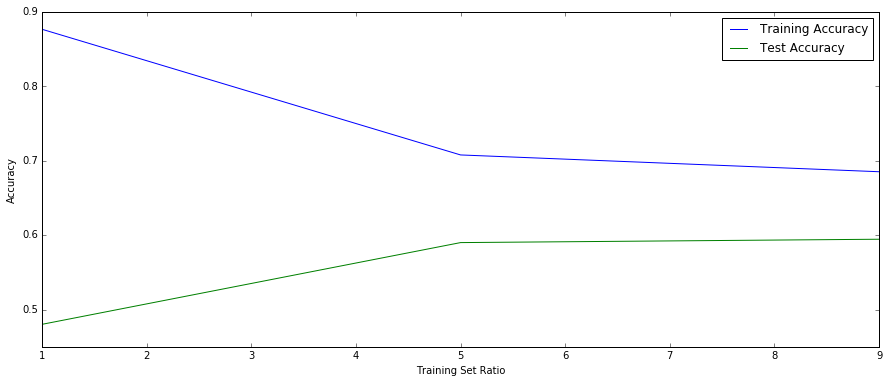

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#crete the figures using collected data 
plt.figure(figsize=(15,6))
tr_acc, = plt.plot(plain_trainRatios,plain_tr_accs,label="Training Accuracy");
test_accuracy, = plt.plot(plain_trainRatios,plain_tst_accs,label="Test Accuracy");
plt.legend(handles=[tr_acc, test_accuracy])
plt.ylabel('Accuracy')
plt.xlabel('Training Set Ratio')
plt.show()

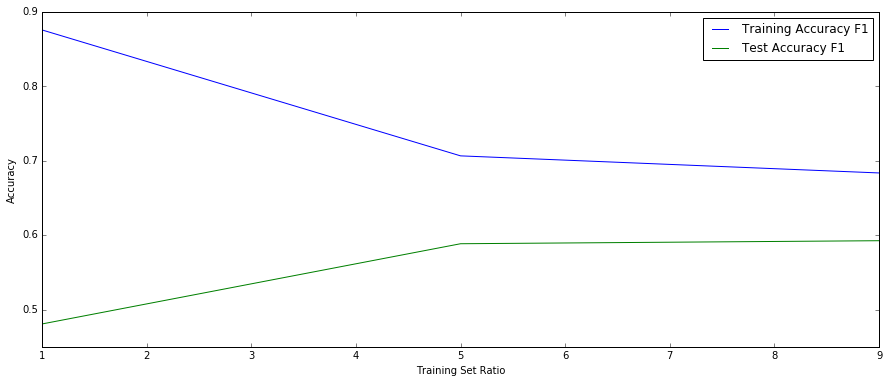

In [11]:
#crete the figures using collected data using f1 measure
plt.figure(figsize=(15,6))
tr_acc_f1, = plt.plot(plain_trainRatios,plain_tr_accs_f1,label="Training Accuracy F1");
test_accuracy_f1, = plt.plot(plain_trainRatios,plain_tst_accs_f1,label="Test Accuracy F1");
plt.legend(handles=[tr_acc_f1, test_accuracy_f1])
plt.ylabel('Accuracy')
plt.xlabel('Training Set Ratio')
plt.show()


#### Observation on Pipeline performance
Above graphical outputs shows an expected behaviour while pipeline was tested under changing training and test data sets. As it can be seen, initially with only 10% training data and 90% test data, the training accuracy was very high due to overfitting. As we increase the size of training data while decreasing the size of test data, the training accuracy goes down from 87% to 70% while the test accuracy increased from 50% to 62% approximately. A similar behaviour was noticed with F1 measure values as described in the second graph above.

This experiment was done without changing any further parameters just to monitor the behaviour of the pipeline and it performed as expected. Following further tasks were then performed to tune the hyper paramters for transformers and classifier.

## Task D - Parameter Grid / Tuning The Classifier

Following task is about parameter tuning through ParamaterGridBuilder class from Machine Learning Library. Following values were provided for tuning purpose:
Hash Vector size using for hashing transformer:  [1000,3000,10000,15000]
Smoothing Factor for naive Bayes estimator: [0,0.2,0.4,0.6,0.8,1]

The grid returns the best model calculated after running the classifier with given tuning paraaters. The training and test accuracies for the best were recorded as shown in the code below:

In [12]:
#create the pramerter grid builder with parameters for hashing and naive bayes
#we added different sizes to the hashing tf and different smoothing levels to the naive bayes
#we have selected these parameters after few experiments 
import time;

paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [1000,3000,10000,15000]) \
    .addGrid(nb.smoothing, [0,0.2,0.4,0.6,0.8,1]) \
    .build()
        
trainValSpliter = TrainValidationSplit(estimator=pipeline, #our pipeline
                               estimatorParamMaps=paramGrid, #parameter grid for grid search
                               evaluator=evaluator, #our multiclass classification evaluator
                               trainRatio=0.8) # we can change this ratio to change the training and validation set size

# Run train validation split and choose the best set of parameters.
tvModel = trainValSpliter.fit(training)

# Make predictions on training documents to get final training accuracy 
prediction = tvModel.transform(training)
trAcc = evaluator.evaluate(prediction)
print("Train accuracy of best model from the gird : ",trAcc)

# Make predictions on test documents. 
prediction = tvModel.transform(testing)
testAcc =  evaluator.evaluate(prediction)
print("Test accuracy of best model from the gird : ",testAcc)


Train accuracy of best model from the gird :  0.9131647971426977
Test accuracy of best model from the gird :  0.7822931785195936


#### Grid parameters
Following code was generated to find the validation accuracy of the classifier while changing the tuning parameters. The output of the code was recorded to identify the parameters that give best performance

In [14]:
#Grid Parameter Results from the model

#this function create a array of items with 3 result values
def GetPerformanceOfParams(parameterResultItems,outputList):
    
    #loop trough resutls list
    for item in parameterResultItems:
        #create an empty array to hold 3 elements
        localItemList = [];
        #first element is accuracy and we can get that from item itself
        localItemList.append(item[0]);
        #parameter values are in a dictionary and we get items from the dictionary to loop through it 
        #here we got only 2 parameters since we have set only 2 parameters in the grid
        for key,value in item[1].items():
            #add the parameter to local list
            localItemList.append(value);
        #create list of [accuracy,param1,param2] items
        outputList.append(localItemList);
        
    return;

#make a list out of results from the model. here we combine the accuracy from validationmetics and parameters from estimatorparam maps
resultItems =  list(zip(tvModel.validationMetrics, tvModel.getEstimatorParamMaps()))

#create an empty array to hold the cleand results to produce graphs
outputList = [];

#call the result extract method with the combined results list
GetPerformanceOfParams(resultItems,outputList);

#print the output results to check the values
print("\t Accuracy \t Naive Bayes Smoothing \t HashingTF Size")
for i in outputList:
    print("{0} \t\t {1} \t\t {2}".format(i[0],i[2],i[1]))
    

	 Accuracy 	 Naive Bayes Smoothing 	 HashingTF Size
0.5109366236679753 		 0 		 1000
0.511497476163769 		 0.2 		 1000
0.5117779024116658 		 0.4 		 1000
0.5117779024116658 		 0.6 		 1000
0.5117779024116658 		 0.8 		 1000
0.5123387549074594 		 1 		 1000
0.6472237801458216 		 0 		 3000
0.6483454851374089 		 0.2 		 3000
0.6475042063937184 		 0.4 		 3000
0.6469433538979249 		 0.6 		 3000
0.6463825014021313 		 0.8 		 3000
0.6463825014021313 		 1 		 3000
0.38895120583286596 		 0 		 10000
0.7462142456533931 		 0.2 		 10000
0.7453729669097028 		 0.4 		 10000
0.7445316881660123 		 0.6 		 10000
0.7459338194054963 		 0.8 		 10000
0.7462142456533931 		 1 		 10000
0.25294447560291644 		 0 		 15000
0.7708917554683118 		 0.2 		 15000
0.7689287717330342 		 0.4 		 15000
0.7697700504767246 		 0.6 		 15000
0.7675266404935502 		 0.8 		 15000
0.7647223780145822 		 1 		 15000


### OBSERVATIONS

From the above output, it can be seen that the accuracy of the classifier goes up as we increase the hash vector size within the hashingTF transformer. Best value for hashing vector size was found to be between 10,000 and 15,000 with the maximum accuracy of 77% with hash vector size of 15,000. It was also noted that a bigger hash vector size takes a longer time for the classifier to process the given data. 

The smoothing parameter for naive Bayes classifier also had a noticable affect on the accuracy. Different smoothing values from 0 (no smoothing) to 1 were supplied to the grid. Values greater than 1 resulted as acuracy getting lower in our previous experiments to it was decided to limit the range between 0 and 1. The best value for smoothing parameter was found to be between 0.2 and 0.4, where the accuracy was found to be 75 - 77%. 

Using the best values identified in the experiment above, we created an updated Pipeline with hashing value 15000 and a smoothing factor of 0.2. Rest of the values for transformers and other paramaters were kept the same as previous to their default values. Following code defines a tuned classifier for the final test.

In [15]:
#Update the pipeline using best values

#hashing transformer to crete hash out of words
hashingTF = HashingTF(inputCol=remover.getOutputCol(), outputCol="features", numFeatures = 15000)
nb = NaiveBayes(smoothing=0.2, modelType="multinomial")

pipeline = Pipeline(stages=[tokenizer,remover, hashingTF, nb])

### Experiment with  training and test size and their impact on time

In order to identify the impact the size of training and test dataset with the final classifier, following experiment was performed where iteratively change the size of test and train data while recording the time taken for each run of the classifier.

In [16]:
#create an empty array to keep time results for each calculation
trainingTimes = [];
testTimes = [];
trainingAccuracies = [];
testAccuracies = [];
totalTimes = [];
trainingSizes = [];
trainRatios = [4.0,6.0,7.0,8.0,9.0];

#loop through list of numbers we defined as ratio for the train validation split method. in this method we devide our 
#training set further into training and validation sets. Then we do final test with our main test dataset.
print("Ratio \t Training Size \t Test Size \t Training Acc. \t Training Time \t Test Acc. \t Test Time \t Total Time ")

for trainRatio in trainRatios:
    #create training and test datasets from our main dataset.
    [training,testing] = rows_DF.randomSplit([trainRatio,10-trainRatio])
    training.cache();
    testing.cache();
    #get the start time for calculation
    time1 = time.time();
    
    #train the classifier in pipeline
    model = pipeline.fit(training)
    
    #get the time after training the model
    time2 = time.time();
    
    # Make predictions on training documents to get final training accuracy 
    prediction = model.transform(training)
    trAcc = evaluator.evaluate(prediction)
    #get the time after prediction with training data
    time3 = time.time();
    
    # Make predictions on test documents. 
    prediction = model.transform(testing)
    testAcc =  evaluator.evaluate(prediction)
    
    #get the time at the end of the calculation
    time4 = time.time();
    
    #calculating time differences
    trTime = time2 - time1;
    testTime = time4 - time3;
    totalTime = time4 - time1;
    trainingSize = training.count();
    
    #adding results to list to produce graphs
    trainingTimes.append(trTime);
    testTimes.append(testTime);
    totalTimes.append(totalTime);
    trainingAccuracies.append(trAcc);
    trainingSizes.append(trainingSize);
    testAccuracies.append(testAcc);
    print("{0}\t{1}\t\t {2}\t\t {3}\t\t {4}\t\t {5}\t\t {6}\t\t {7}".format(trainRatio,trainingSize,\
        testing.count(),str(round(trAcc*100, 2)),str(round(trTime, 2)),str(round(testAcc * 100, 2)),str(round(testTime, 2)),str(round(totalTime, 2))))
  
    

Ratio 	 Training Size 	 Test Size 	 Training Acc. 	 Training Time 	 Test Acc. 	 Test Time 	 Total Time 
4.0	8127		 11859		 95.1		 1.85		 74.61		 4.66		 9.82
6.0	11805		 8181		 93.04		 2.38		 76.62		 3.61		 10.52
7.0	14028		 5958		 92.75		 2.96		 77.04		 2.94		 11.13
8.0	16069		 3917		 91.95		 3.18		 77.58		 2.3		 11.3
9.0	17989		 1997		 91.44		 3.41		 78.62		 1.82		 11.47


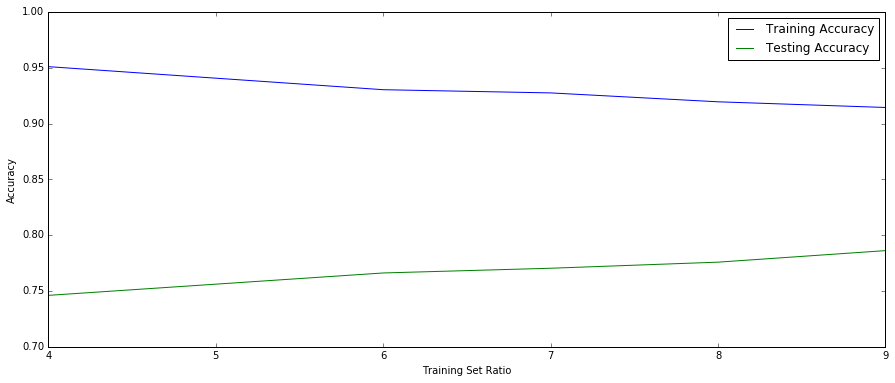

In [17]:
#create figures of training and test accuracies
plt.figure(figsize=(15,6))
f_training_accracies, = plt.plot(trainRatios,trainingAccuracies,label="Training Accuracy");
f_testing_accracies, = plt.plot(trainRatios,testAccuracies,label="Testing Accuracy");
plt.legend(handles=[f_training_accracies,f_testing_accracies])
plt.ylabel('Accuracy')
plt.xlabel('Training Set Ratio')
plt.show()

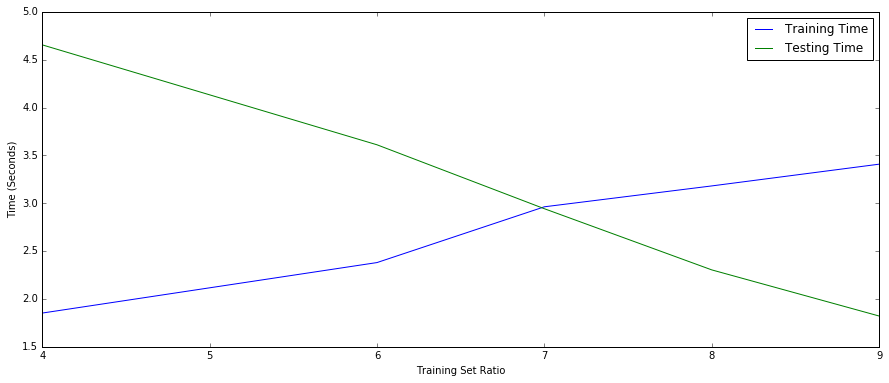

In [18]:
#create figures of training and test times
plt.figure(figsize=(15,6))
f_training_time, = plt.plot(trainRatios,trainingTimes,label="Training Time");
f_test_time, = plt.plot(trainRatios,testTimes,label="Testing Time");
plt.legend(handles=[f_training_time,f_test_time])
plt.ylabel('Time (Seconds)')
plt.xlabel('Training Set Ratio')
plt.show()

#### OBERVATIONS 
In the above experiment, it was observed that with the increase in the size of the training data, more time was taken to train the classifier. The test accuracy also increased with the incrase in training data size as observed in the previous experiment. Going from an initial split of 40-60 (train/test) to 90-10 (train/test) and resulting graphs above re-affirm the ideas of overfitting and efficiency with respect to an increase in training data size.  

### Experiment  with domain grouping 

Following extra exeperiment was performed to further explore the text classification process using the model described above. In this experiment, we decided to group together document from similar topics as shown in section 1. Five new classes (groups) were defined as Computing, Recreation, Politics, Science, Religion and Misc. We defined new labels for these classes and performed the experiment with the optimized values for the classifier as described above. 

In [19]:
#experiment with categorized new groups

#create lists of categories
listOfCategories = {'Computing':['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x'],
                   'Recreation':['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'],
                   'Politics':['talk.politics.misc', 'talk.politics.guns', 'talk.politics.mideast'],
                   'Science':['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'],
                   'Religion':['talk.religion.misc', 'alt.atheism', 'soc.religion.christian'],
                   'Misc':['misc.forsale']}; 

rows_DF_exp2 = None;

number = 0;
for i in listOfCategories:
    for topic in listOfCategories[i]: 
        #make a dataframe for given topic and save it in a tempory variable
        rows_temp_DF = make_dataFrame(prefix+topic, number)
    
        #main dataframe is not null except in the first case. we merge the tempory df to main df
        if(rows_DF_exp2 is not None):
            rows_DF_exp2 = rows_DF_exp2.union(rows_temp_DF)
        else:
            #first case main dataframe is null and just assgin tempory df to main df
            rows_DF_exp2 = rows_temp_DF;
            
    number = number + 1;

In [20]:
#create a view called newsgroups in the dataframe
rows_DF_exp2.createOrReplaceTempView("newsgroups")

#create training and test datasets from our main dataset.
[train_DF_exp2,test_DF_exp2] = rows_DF_exp2.randomSplit([8.0,2.0])

#format and count of the test dataset
test_DF_exp2.groupBy('label').count().orderBy('label').show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  614|
|    1| 1008|
|    2|  825|
|    3|  828|
|    4|  648|
|    5|  203|
+-----+-----+



In [21]:
#assign train and test dataframes to new variables and add them to cache to speed up the experiment
training_exp2 = train_DF_exp2 
testing_exp2 = test_DF_exp2

#cache to speed up the access
training_exp2.cache();
testing_exp2.cache();

#mesaure the start time
time1 = time.time();

#train the model using pipeline
model = pipeline.fit(training_exp2)
#measure the time after training the model
time2 = time.time(); 
print("Time for training the model: ", time2 - time1)

# Make predictions on training documents to get final training accuracy 
prediction = model.transform(training_exp2)
print("training accuracy: ", evaluator.evaluate(prediction))
#mesaure the time after prediction with training data
time3 = time.time(); 
print("Time for Prediction with training data: ", time3 - time2)

# Make predictions on test documents. 
prediction = model.transform(testing_exp2)
print("testing accuracy: ", evaluator.evaluate(prediction))
#mesaure the time after prediction with test data
time4 = time.time(); 
print("Time for Prediction with Test data: ", time4 - time3)

Time for training the model:  110.3638117313385
training accuracy:  0.9095208070617906
Time for Prediction with training data:  5.197361946105957
testing accuracy:  0.8589432864760058
Time for Prediction with Test data:  106.62399387359619


#### OBSERVATIONS

As shown in the results above, it was observed that the overall prediction accuracy of the classifier was much higher than what was seen with individual topic classification. Going from 20 classes to 6 classes as described above, the accuracy moved from 77% to 85%. This increase in accuracy can be explained by the idea that a smaller number of classes give a higher probability for each document to belong to a certain class i.e. with 20 classes the probablity of a document of belonging to a random class would be 1/20 = 0.05. Whereas, with 6 classes,  the probablity of a document to belong to a random class increases to 1/6 = 0.17. It can hence be concluded that with a decrease in the number of classes, and an increase in the training data size, the overall performance for balanaced data gets improved considerably. This observation is well in line with the literature mentioned earlier. 

### CONCLUSION

In conclusion, The set of experiments above provided an insight into the application of naive Bayes algorithm for text classification purpose in a Big Data domain. The experiment involved creating a Pipeline object in Spark and identifying different stages for data transofrmation, evaluation and parameter tuning. It can be stated that tuned parameter defined after the optimization stages, was accurate and fast enough to be deployed as an online, large scale document classification system. As future experiment, there are plans to use a similar classifier to classify RSS feeds or other streaming documents according to user prefernces to offer a personalised information delivery system. 

### REFERENCES

1. http://qwone.com/~jason/20Newsgroups/ (20 Newsgroup Dataset Official site)

2. Lang, K., 1995, July. Newsweeder: Learning to filter netnews. In Proceedings of the 12th international conference on machine    learning (pp. 331-339).

3. Venezky, R.L., 1970. The structure of English orthography (Vol. 82). Walter de Gruyter.

4. Aggarwal, C.C. and Zhai, C. eds., 2012. Mining text data. Springer Science & Business Media.

5. Zhang, H., 2004. The optimality of naive Bayes. AA, 1(2), p.3.

6. https://github.com/brez (John Bresnik’s Github Respository) 